In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
import keras
physical_devices = tf.test.gpu_device_name()
print(physical_devices)

from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

import datasets

import numpy as np

/device:GPU:0


c:\Users\Tim\miniconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from transformers import BeitImageProcessor, BeitForImageClassification

processor = BeitImageProcessor.from_pretrained('TimKond/diffusion-detection')

def ds_preprocess_image(entity):
    img = entity["image"]
    width, height = img.size
    target_size = min(width, height)
    left = max(0, (width - target_size ) // 2)
    right = left + target_size
    top = max(0, (height - target_size ) // 2)
    bottom = top + target_size
    crop = img.crop((left, top, right, bottom)).convert('RGB')
    resize = crop.resize((224,224))
    #process = processor(resize)
    #transformed = np.transpose(np.array(  process["pixel_values"][0]  ), (1,2,0)) 
    #entity["image"] = transformed
    entity["image"] = resize
    return entity

In [3]:
def preprocess_image(img):
    width, height = img.size
    target_size = min(width, height)
    left = max(0, (width - target_size ) // 2)
    right = left + target_size
    top = max(0, (height - target_size ) // 2)
    bottom = top + target_size
    crop = img.crop((left, top, right, bottom)).convert('RGB')
    resize = crop.resize((224,224))
    process = processor(resize)["pixel_values"][0]
    return np.array(process)
    # return np.array(resize)

In [4]:
preprocess = False
if preprocess:

    # load image data

    ds = datasets.load_from_disk("../../data/diffusion_and_real/")

    # train_images = np.array([preprocess_image(image) for image in ds["train"]["image"]])
    # train_labels = np.array(ds["train"]["label"])

    # vali_images = np.array([preprocess_image(image) for image in ds["vali"]["image"]])
    # vali_labels = np.array(ds["vali"]["label"])

    # test_images = np.array([preprocess_image(image) for image in ds["test"]["image"]])
    # test_labels = np.array(ds["test"]["label"])

    ds_map = ds.map(ds_preprocess_image)

    ds_tf = ds_map.with_format("tf")

    ds_tf.save_to_disk("ds-tf-224")
else:
    ds_tf = datasets.load_from_disk("ds-tf-224")

In [5]:
ds_tf_train = ds_tf["train"].to_tf_dataset(
            columns=["image"],
            label_cols=["label"],
            batch_size=1,
            shuffle=True
            )

ds_tf_vali = ds_tf["vali"].to_tf_dataset(
            columns=["image"],
            label_cols=["label"],
            batch_size=1,
            shuffle=True
            )

ds_tf_test = ds_tf["test"].to_tf_dataset(
            columns=["image"],
            label_cols=["label"],
            batch_size=1,
            shuffle=True
            )

c:\Users\Tim\miniconda3\lib\site-packages\datasets\arrow_dataset.py:385: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [6]:
model = models.Sequential()
model.add(layers.Conv2D(4, (5, 5), activation='relu', input_shape=(224, 224, 3)))
#model.add(layers.Conv2D(8, (9, 9), activation='relu', input_shape=(512, 512, 3)))
model.add(layers.MaxPooling2D((4, 4)))
model.add(layers.Conv2D(8, (7, 7), strides=(2,2),activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# Fully connected layers
model.add(layers.Flatten())
#model.add(layers.Dense(10, activation='sigmoid')) #removed for now to keep the network simple and fast 
#model.add(layers.Dense(1, activation = "sigmoid"))
model.add(layers.Dense(1, activation = "relu"))
#model.add(layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 4)       304       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 55, 55, 4)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 8)         1576      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 8)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 1)                 1

In [7]:
[print(i.shape, i.dtype) for i in model.inputs]
[print(o.shape, o.dtype) for o in model.outputs]
[print(l.name, l.input_shape, l.dtype) for l in model.layers]

(None, 224, 224, 3) <dtype: 'float32'>
(None, 1) <dtype: 'float32'>
conv2d (None, 224, 224, 3) float32
max_pooling2d (None, 220, 220, 4) float32
conv2d_1 (None, 55, 55, 4) float32
max_pooling2d_1 (None, 25, 25, 8) float32
flatten (None, 12, 12, 8) float32
dense (None, 1152) float32


[None, None, None, None, None, None]

In [ ]:
inputs = keras.Input(shape=(224, 224, 3))
preprocessing_layer = layers.Normalization()
x = preprocessing_layer(inputs)
outputs = model(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),  # dear god let this be the right loss function
              metrics=['accuracy'])

history = model.fit(ds_tf_train, epochs=10, batch_size = 32, max_queue_size=10, shuffle=True,
                    validation_data=ds_tf_vali
                    )

Epoch 1/10
16019/18000 [=========================>....] - ETA: 7s - loss: 0.6935 - accuracy: 0.4997

16320/18000 [==========================>...] - ETA: 6s - loss: 0.6934 - accuracy: 0.4983

In [ ]:
#model.save("CNN-2")

1000/1000 - 3s - loss: 0.6932 - accuracy: 0.5120 - 3s/epoch - 3ms/step


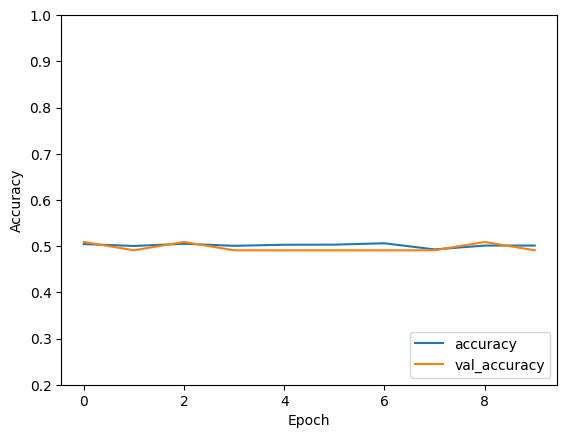

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.2, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(ds_tf_test, verbose=2)


In [ ]:
print(test_acc)


0.5120000243186951
